In [13]:
import numpy as np
import random
import pandas as pd
import gzip

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn import preprocessing

In [70]:
train_df_full = pd.read_csv("train.gz", compression='gzip', header='infer')

In [71]:
train_df_full.shape

(2683787, 24)

In [72]:
def get_date(hour):
    y = '20'+str(hour)[:2]
    m = str(hour)[2:4]
    d = str(hour)[4:6]
    return y+'-'+m+'-'+d
# 建立weekday欄位，將hour轉換後填入
train_df_full['weekday'] = pd.to_datetime(train_df_full.hour.apply(get_date)).dt.dayofweek.astype(str)
train_df_full['weekday'].value_counts()

1    2590484
2      93303
Name: weekday, dtype: int64

In [73]:
train_df_full = train_df_full[train_df_full['weekday'] == "1"]

In [74]:
train_df_full.drop('weekday', axis=1, inplace=True)

In [75]:
def get_hour(hour):
    h = str(hour)[-2:]
    return h

train_df_full['hour'] = train_df_full.hour.apply(get_hour)

Text(0.5, 1.0, 'Number of clicks by hour')

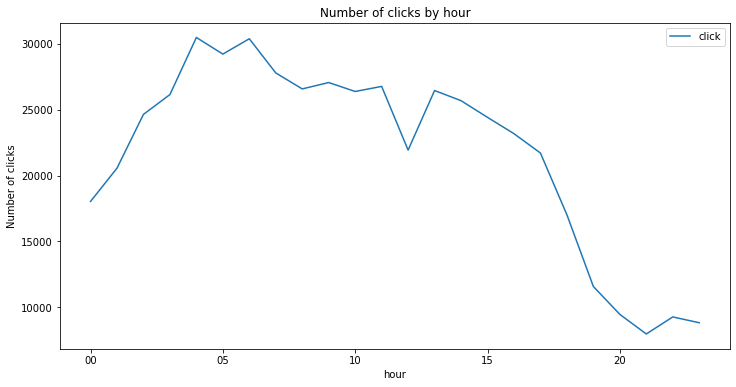

In [76]:
train_df_full.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour')

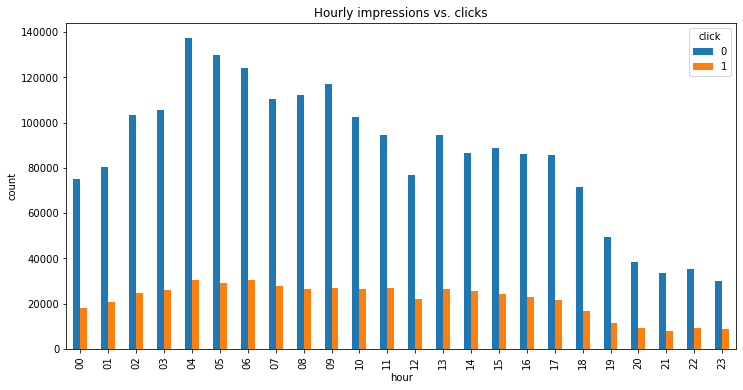

In [29]:
train_df_full.groupby(['hour', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

### C1

In [30]:
print(train_df_full.C1.value_counts()/len(train_df_full))

5     0.941047
2     0.056279
12    0.002624
1     0.000046
10    0.000005
Name: C1, dtype: float64


In [34]:
df_click = train_df_full[train_df_full['click'] == 1]

Text(0.5, 1.0, 'CTR by C1')

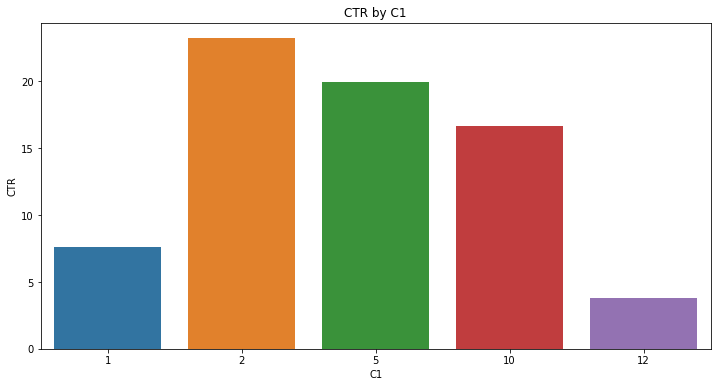

In [35]:
df_c1 = train_df_full[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1')

### Banner position

In [36]:
train_df_full.banner_pos.value_counts()/len(train_df_full)

0    0.639606
1    0.359692
2    0.000504
4    0.000191
3    0.000007
Name: banner_pos, dtype: float64

In [83]:
banner_pos = train_df_full.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train_df_full.loc[np.where((train_df_full.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.19719425984480554
for banner position: 1,  click through rate: 0.20878171493823092
for banner position: 2,  click through rate: 0.11570881226053639
for banner position: 3,  click through rate: 0.0
for banner position: 4,  click through rate: 0.14717741935483872


<AxesSubplot:title={'center':'banner position histogram'}, xlabel='banner_pos'>

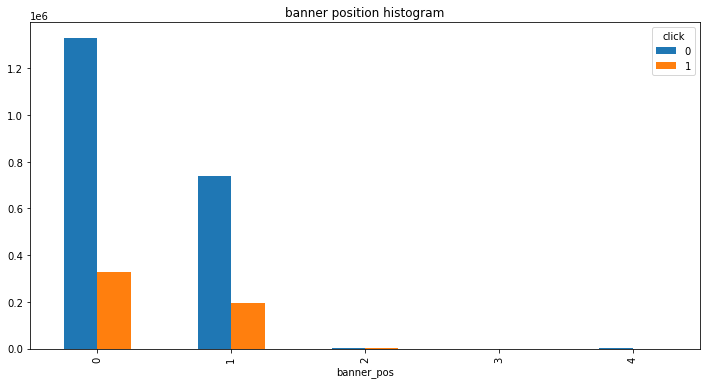

In [37]:
train_df_full.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram')

Text(0.5, 1.0, 'CTR by banner position')

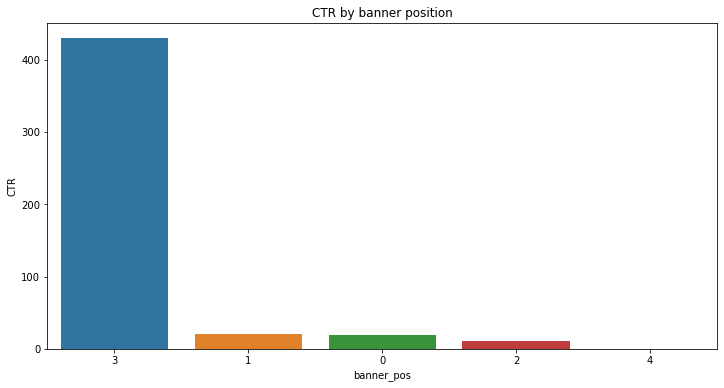

In [38]:
df_banner = train_df_full[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position')

### site id

In [39]:
train_df_full.site_id.nunique()

2864

In [41]:
print('The top 10 site ids that have the most impressions')
print((train_df_full.site_id.value_counts()/len(train_df_full))[0:10])

The top 10 site ids that have the most impressions
078d3465    0.297992
c12ebe86    0.081864
8480f5b7    0.058017
50d76ac2    0.030795
d410bf4e    0.029677
760bf05a    0.028070
4407d527    0.016690
656e1ab8    0.015178
175890c0    0.012143
669b678c    0.012089
Name: site_id, dtype: float64


<AxesSubplot:title={'center':'Top 10 site ids histogram'}, xlabel='site_id'>

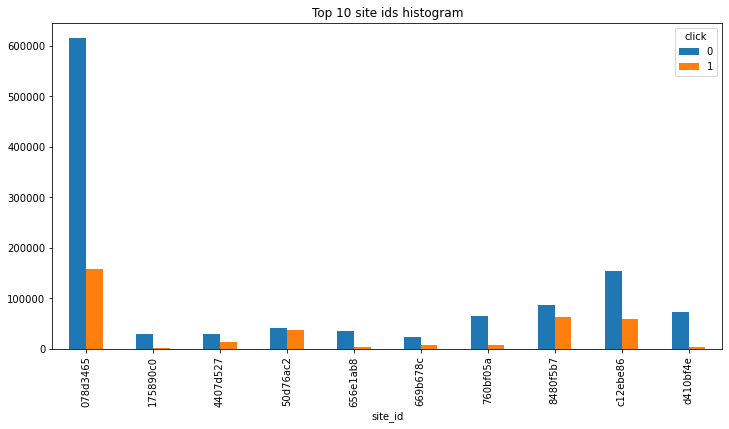

In [42]:
top10_sites = train_df_full[(train_df_full.site_id.isin((train_df_full.site_id.value_counts()/len(train_df_full))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['click'] == 1]
top10_sites.groupby(['site_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site ids histogram')

Text(0.5, 1.0, 'CTR by top 10 site id')

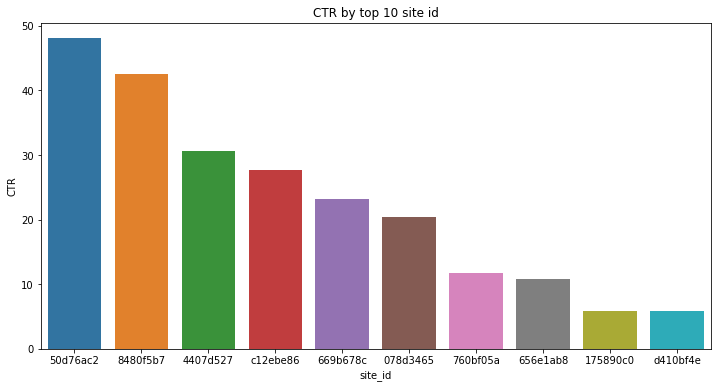

In [43]:
df_site = top10_sites[['site_id','click']].groupby(['site_id']).count().reset_index()
df_site = df_site.rename(columns={'click': 'impressions'})
df_site['clicks'] = top10_sites_click[['site_id','click']].groupby(['site_id']).count().reset_index()['click']
df_site['CTR'] = df_site['clicks']/df_site['impressions']*100
sort_site = df_site.sort_values(by='CTR',ascending=False)['site_id'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_id', data=df_site, order=sort_site)
plt.title('CTR by top 10 site id')

### site domain

In [44]:
print("There are {} site domains in the data set".format(train_df_full.site_domain.nunique()))

There are 3394 site domains in the data set


In [45]:
print('The top 10 site domains that have the most impressions')
print((train_df_full.site_domain.value_counts()/len(train_df_full))[0:10])

The top 10 site domains that have the most impressions
dd641cc7    0.297992
c1aa3c04    0.085906
3eda54e5    0.060946
1c7daf87    0.042654
b93564ec    0.030041
dfe994f8    0.029677
eb0937cb    0.022938
a68154ff    0.016805
daedb01e    0.015597
59fdbcde    0.015178
Name: site_domain, dtype: float64


In [48]:
top10_domains = (train_df_full.site_domain.value_counts()/len(train_df_full))[0:10].index
click_avg_list=[]

for i in top10_domains:
    click_avg=train_df_full.loc[np.where((train_df_full.site_domain == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site domain value: {},  click through rate: {}".format(i,click_avg))

for site domain value: dd641cc7,  click through rate: 0.20377514431098628
for site domain value: c1aa3c04,  click through rate: 0.26747012856289065
for site domain value: 3eda54e5,  click through rate: 0.4144350139346339
for site domain value: 1c7daf87,  click through rate: 0.4758767365039142
for site domain value: b93564ec,  click through rate: 0.12835701986584772
for site domain value: dfe994f8,  click through rate: 0.05815632357340756
for site domain value: eb0937cb,  click through rate: 0.2413793103448276
for site domain value: a68154ff,  click through rate: 0.304160062481336
for site domain value: daedb01e,  click through rate: 0.08529069623542807
for site domain value: 59fdbcde,  click through rate: 0.10857346321117017


<AxesSubplot:title={'center':'Top 10 site domains histogram'}, xlabel='site_domain'>

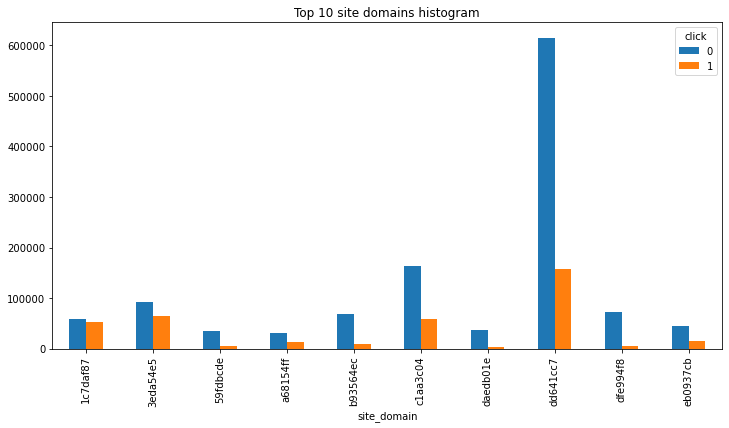

In [49]:
top10_domain = train_df_full[(train_df_full.site_domain.isin((train_df_full.site_domain.value_counts()/len(train_df_full))[0:10].index))]
top10_domain_click = top10_domain[top10_domain['click'] == 1]
top10_domain.groupby(['site_domain', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site domains histogram')

Text(0.5, 1.0, 'CTR by top 10 site domain')

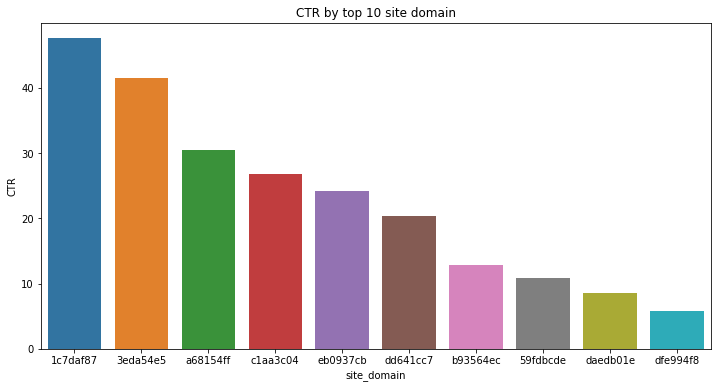

In [50]:
df_domain = top10_domain[['site_domain','click']].groupby(['site_domain']).count().reset_index()
df_domain = df_domain.rename(columns={'click': 'impressions'})
df_domain['clicks'] = top10_domain_click[['site_domain','click']].groupby(['site_domain']).count().reset_index()['click']
df_domain['CTR'] = df_domain['clicks']/df_domain['impressions']*100
sort_domain = df_domain.sort_values(by='CTR',ascending=False)['site_domain'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_domain', data=df_domain, order=sort_domain)
plt.title('CTR by top 10 site domain')

### site category

In [51]:
print("There are {} site categories in the data set".format(train_df_full.site_category.nunique()))

There are 22 site categories in the data set


In [52]:
print('The top 10 site categories that have the most impressions')
print((train_df_full.site_category.value_counts()/len(train_df_full))[0:10])

The top 10 site categories that have the most impressions
74073276    0.444353
8fd0aea4    0.347737
f66779e6    0.108805
28905ebd    0.056294
9ccfa2ea    0.014734
bcf865d9    0.007282
110ab22d    0.005079
dedf689d    0.005015
72722551    0.003116
76b2941d    0.003059
Name: site_category, dtype: float64


In [53]:
top10_categories = (train_df_full.site_category.value_counts()/len(train_df_full))[0:10].index
click_avg_list=[]

for i in top10_categories:
    click_avg=train_df_full.loc[np.where((train_df_full.site_category == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site category value: {},  click through rate: {}".format(i,click_avg))

for site category value: 74073276,  click through rate: 0.198556323620502
for site category value: 8fd0aea4,  click through rate: 0.1967979822536903
for site category value: f66779e6,  click through rate: 0.2638536562866986
for site category value: 28905ebd,  click through rate: 0.23232849658501797
for site category value: 9ccfa2ea,  click through rate: 0.024183194906594704
for site category value: bcf865d9,  click through rate: 0.10311191220908657
for site category value: 110ab22d,  click through rate: 0.15085879312965497
for site category value: dedf689d,  click through rate: 0.028789161727349702
for site category value: 72722551,  click through rate: 0.03171064040629258
for site category value: 76b2941d,  click through rate: 0.08075709779179811


<AxesSubplot:title={'center':'Top 10 site categories histogram'}, xlabel='site_category'>

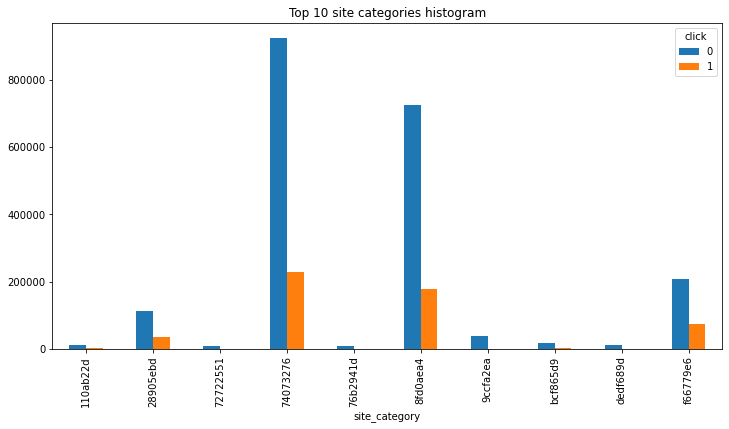

In [54]:
top10_category = train_df_full[(train_df_full.site_category.isin((train_df_full.site_category.value_counts()/len(train_df_full))[0:10].index))]
top10_category_click = top10_category[top10_category['click'] == 1]
top10_category.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site categories histogram')

Text(0.5, 1.0, 'CTR by top 10 site category')

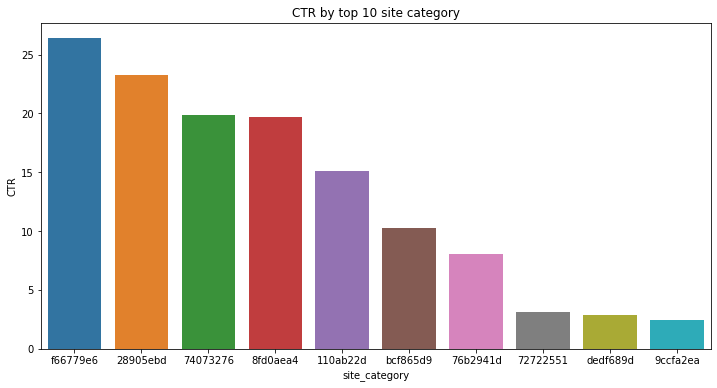

In [55]:
df_category = top10_category[['site_category','click']].groupby(['site_category']).count().reset_index()
df_category = df_category.rename(columns={'click': 'impressions'})
df_category['clicks'] = top10_category_click[['site_category','click']].groupby(['site_category']).count().reset_index()['click']
df_category['CTR'] = df_category['clicks']/df_category['impressions']*100
sort_category = df_category.sort_values(by='CTR',ascending=False)['site_category'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_category', data=df_category, order=sort_category)
plt.title('CTR by top 10 site category')

### device id

In [56]:
print("There are {} devices in the data set".format(train_df_full.device_id.nunique()))

There are 81780 devices in the data set


In [57]:
print('The top 10 devices that have the most impressions')
print((train_df_full.device_id.value_counts()/len(train_df_full))[0:10])

The top 10 devices that have the most impressions
a99f214a    0.944046
c357dbff    0.003070
0f7c61dc    0.000114
05f75302    0.000058
76420194    0.000056
7ba9d41e    0.000044
368b0fce    0.000040
64ddfd07    0.000039
9bd20c03    0.000034
3c0208dc    0.000032
Name: device_id, dtype: float64


In [58]:
top10_devices = (train_df_full.device_id.value_counts()/len(train_df_full))[0:10].index
click_avg_list=[]

for i in top10_devices:
    click_avg=train_df_full.loc[np.where((train_df_full.device_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device id value: {},  click through rate: {}".format(i,click_avg))

for device id value: a99f214a,  click through rate: 0.19950399401357985
for device id value: c357dbff,  click through rate: 0.6469700779482022
for device id value: 0f7c61dc,  click through rate: 0.8006756756756757
for device id value: 05f75302,  click through rate: 0.0
for device id value: 76420194,  click through rate: 0.0
for device id value: 7ba9d41e,  click through rate: 0.0
for device id value: 368b0fce,  click through rate: 0.06796116504854369
for device id value: 64ddfd07,  click through rate: 0.0
for device id value: 9bd20c03,  click through rate: 0.0
for device id value: 3c0208dc,  click through rate: 0.0


<AxesSubplot:title={'center':'Top 10 device ids histogram'}, xlabel='device_id'>

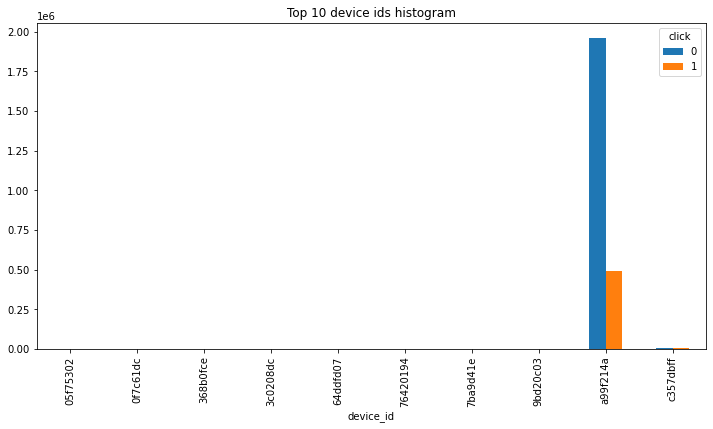

In [59]:
top10_device = train_df_full[(train_df_full.device_id.isin((train_df_full.device_id.value_counts()/len(train_df_full))[0:10].index))]
top10_device_click = top10_device[top10_device['click'] == 1]
top10_device.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 device ids histogram')

### device ip

In [61]:
print("There are {} device ips in the data set".format(train_df_full.device_ip.nunique()))
print("There are {} device types in the data set".format(train_df_full.device_type.nunique()))
print("There are {} device models in the data set".format(train_df_full.device_model.nunique()))
print("There are {} device cnn types in the data set".format(train_df_full.device_conn_type.nunique()))

There are 662233 device ips in the data set
There are 4 device types in the data set
There are 4790 device models in the data set
There are 2 device cnn types in the data set


In [84]:
print('The top 10 device ip that have the most impressions')
print((train_df_full.device_ip.value_counts()/len(train_df_full))[0:10])

The top 10 device ip that have the most impressions
6b9769f2    0.008140
431b3174    0.004882
c6563308    0.002866
1cf29716    0.002862
75bb1b58    0.002855
ddd2926e    0.002831
0489ce3f    0.002816
ceffea69    0.002801
57cd4006    0.002782
488a9a3e    0.002770
Name: device_ip, dtype: float64


In [88]:
top10_device_ip = (train_df_full.device_ip.value_counts()/len(train_df_full))[0:10].index
click_avg_list=[]

for i in top10_device_ip:
    click_avg=train_df_full.loc[np.where((train_df_full.device_ip == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device ip value: {},  click through rate: {}".format(i,click_avg))

for device ip value: 6b9769f2,  click through rate: 0.2504979607322394
for device ip value: 431b3174,  click through rate: 0.21220746363061355
for device ip value: c6563308,  click through rate: 0.24313038793103448
for device ip value: 1cf29716,  click through rate: 0.25104546067718875
for device ip value: 75bb1b58,  click through rate: 0.2527383367139959
for device ip value: ddd2926e,  click through rate: 0.24515953095173165
for device ip value: 0489ce3f,  click through rate: 0.2598025774609268
for device ip value: ceffea69,  click through rate: 0.25909592061742004
for device ip value: 57cd4006,  click through rate: 0.25520399666944216
for device ip value: 488a9a3e,  click through rate: 0.24501742160278744


### device type

In [62]:
print('The impressions by device types')
print((train_df_full.device_type.value_counts()/len(train_df_full)))

The impressions by device types
1    9.437167e-01
0    5.627867e-02
5    3.860282e-06
4    7.720565e-07
Name: device_type, dtype: float64


<AxesSubplot:title={'center':'device types'}, xlabel='device_type'>

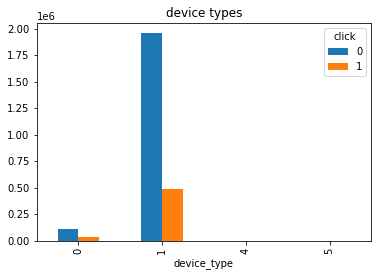

In [63]:
train_df_full[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types')

In [64]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train_df_full.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')

In [65]:
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100

In [66]:
merged_device_type

,device_type,click,impressions,CTR
0,0,33880,145789,23.239065
1,1,487609,2444683,19.945694
2,4,1,2,50.000000
3,5,1,10,10.000000


In [68]:
train_df_full[train_df_full["device_type"] == 4]

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1708162,1708163,0,13,10,0,80e454ae,eb0937cb,74073276,ecda2021,2021c8a9,...,4,0,17863,181,231,1614,3,15,153,144
2496920,2496921,1,21,10,0,1df47d50,eb0937cb,74073276,ecda2021,2021c8a9,...,4,0,20346,181,231,1909,2,7,-1,11


### device models

In [90]:
print('The impressions by device models')
print((train_df_full.device_model.value_counts()/len(train_df_full))[0:10])

The impressions by device models
8a4875bd    0.092873
d787e91b    0.043546
1f0bc64f    0.038321
76dc4769    0.025769
a0f5f879    0.022766
4ea23a13    0.021115
711ee120    0.019621
be6db1d7    0.018714
ecb851b2    0.017592
84ebbcd4    0.017245
Name: device_model, dtype: float64


In [91]:
top10_device_model = (train_df_full.device_model.value_counts()/len(train_df_full))[0:10].index
click_avg_list=[]

for i in top10_device_model:
    click_avg=train_df_full.loc[np.where((train_df_full.device_model == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device ip value: {},  click through rate: {}".format(i,click_avg))

for device ip value: 8a4875bd,  click through rate: 0.14251927593158342
for device ip value: d787e91b,  click through rate: 0.22936243395624267
for device ip value: 1f0bc64f,  click through rate: 0.22889867131387817
for device ip value: 76dc4769,  click through rate: 0.19414857759201834
for device ip value: a0f5f879,  click through rate: 0.17383637134378974
for device ip value: 4ea23a13,  click through rate: 0.22739405462722587
for device ip value: 711ee120,  click through rate: 0.23649884908221686
for device ip value: be6db1d7,  click through rate: 0.16624035645034863
for device ip value: ecb851b2,  click through rate: 0.19418050953457242
for device ip value: 84ebbcd4,  click through rate: 0.3471448078257561


### device conn types

In [92]:
print('The impressions by device cnn types')
print((train_df_full.device_conn_type.value_counts()/len(train_df_full)))

The impressions by device cnn types
0    0.956549
2    0.043451
Name: device_conn_type, dtype: float64


In [94]:
device_conn_type_click = df_click.groupby('device_conn_type').agg({'click':'sum'}).reset_index()
device_conn_type_impression = train_df_full.groupby('device_conn_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_conn_type_click , right = device_conn_type_impression, how = 'inner', on = 'device_conn_type')
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100
merged_device_type

,device_conn_type,click,impressions,CTR
0,0,497343,2477924,20.070955
1,2,24148,112560,21.453447


### app features

In [77]:
print("There are {} apps in the data set".format(train_df_full.app_id.nunique()))
print("There are {} app domains in the data set".format(train_df_full.app_domain.nunique()))
print("There are {} app categories in the data set".format(train_df_full.app_category.nunique()))

There are 1 apps in the data set
There are 1 app domains in the data set
There are 1 app categories in the data set


### C14 - C21 features

In [78]:
print("There are {} C14 in the data set".format(train_df_full.C14.nunique()))
print("There are {} C15 in the data set".format(train_df_full.C15.nunique()))
print("There are {} C16 in the data set".format(train_df_full.C16.nunique()))
print("There are {} C17 in the data set".format(train_df_full.C17.nunique()))
print("There are {} C18 in the data set".format(train_df_full.C18.nunique()))
print("There are {} C19 in the data set".format(train_df_full.C19.nunique()))
print("There are {} C20 in the data set".format(train_df_full.C20.nunique()))

There are 590 C14 in the data set
There are 5 C15 in the data set
There are 6 C16 in the data set
There are 153 C17 in the data set
There are 4 C18 in the data set
There are 33 C19 in the data set
There are 166 C20 in the data set


<AxesSubplot:title={'center':'C14 distribution'}, xlabel='C14'>

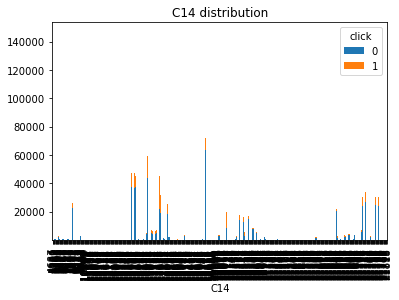

In [95]:
train_df_full.groupby(['C14', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C14 distribution')

<AxesSubplot:title={'center':'C15 distribution'}, xlabel='C15'>

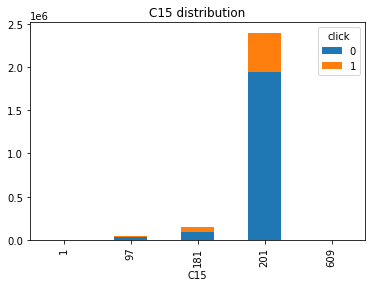

In [79]:
train_df_full.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 distribution')

<AxesSubplot:title={'center':'C16 distribution'}, xlabel='C16'>

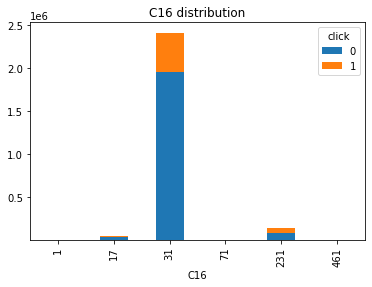

In [80]:
train_df_full.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 distribution')

<AxesSubplot:title={'center':'C17 distribution'}, xlabel='C17'>

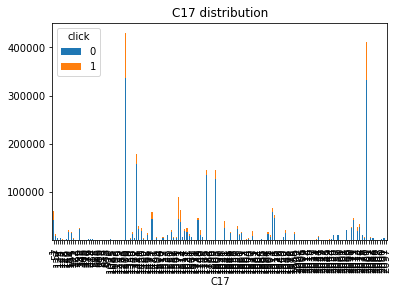

In [96]:
train_df_full.groupby(['C17', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C17 distribution')

<AxesSubplot:title={'center':'C18 distribution'}, xlabel='C18'>

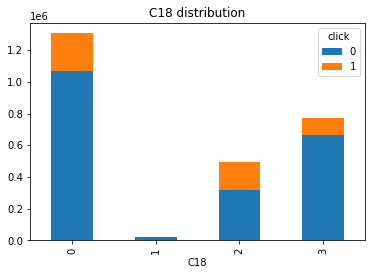

In [81]:
train_df_full.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution')

<AxesSubplot:title={'center':'C19 distribution'}, xlabel='C19'>

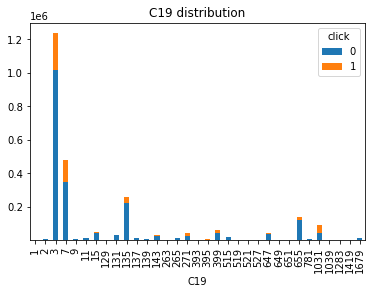

In [97]:
train_df_full.groupby(['C19', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C19 distribution')

<AxesSubplot:title={'center':'C20 distribution'}, xlabel='C20'>

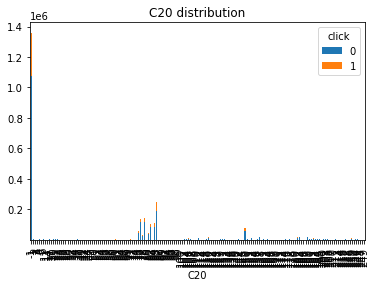

In [98]:
train_df_full.groupby(['C20', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C20 distribution')